# Text Classification for Topic Modelling

## Notebook Imports

In [1]:
# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Sklearn
import sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Imblearn
import imblearn
from imblearn.over_sampling import RandomOverSampler

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from torchtext.vocab import build_vocab_from_iterator

# Other
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
nltk.download('stopwords')
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [4]:
from nltk.corpus import wordnet
! unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

# Data Loading

In [5]:
DATASET_ROOT = '/kaggle/input/topic-modeling-for-research-articles/Train.csv'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
train_df = pd.read_csv(DATASET_ROOT)
train_df.head()

,id,ABSTRACT,Computer Science,Mathematics,Physics,Statistics,Analysis of PDEs,Applications,Artificial Intelligence,Astrophysics of Galaxies,...,Methodology,Number Theory,Optimization and Control,Representation Theory,Robotics,Social and Information Networks,Statistics Theory,Strongly Correlated Electrons,Superconductivity,Systems and Control
0,1824,a ever-growing datasets inside observational a...,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3094,we propose the framework considering optimal $...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8463,nanostructures with open shell transition meta...,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2082,stars are self-gravitating fluids inside which...,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8687,deep neural perception and control networks ar...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Data Preprocessing

In [7]:
# Dropping ID
train_df.drop('id', axis=1, inplace=True)

# Resetting ID 
train_df.reset_index()

topics = train_df.columns[1:]
train_df['Target'] = train_df[topics].idxmax(axis=1)
train_df.drop(topics, axis=1, inplace=True)
train_df.head()

,ABSTRACT,Target
0,a ever-growing datasets inside observational a...,Physics
1,we propose the framework considering optimal $...,Computer Science
2,nanostructures with open shell transition meta...,Physics
3,stars are self-gravitating fluids inside which...,Physics
4,deep neural perception and control networks ar...,Computer Science


In [8]:
encoder = LabelEncoder()
train_df['Target_Label'] = encoder.fit_transform(train_df['Target'])

In [9]:
def preprocess_text(text: str, stopwords=set(stopwords.words('english')), wnl=WordNetLemmatizer(), ml=True):
    
    """
    Preprocesses the input text by tokenizing, removing stopwords and punctuation, and lemmatizing the words.
    
    Args:
        text (str): The input text to be preprocessed.
        stopwords (set, optional): A set of stopwords to be removed from the text. Defaults to nltk's English stopwords.
        wnl (WordNetLemmatizer, optional): An instance of WordNetLemmatizer for lemmatizing words. Defaults to an instance of WordNetLemmatizer.
        ml (bool, optional): If True, the preprocessed text is returned as a single string. If False, the preprocessed text is returned as a list of words. Defaults to True.
    
    Returns:
        list or str: The preprocessed text. If ml is True, returns a string of the preprocessed text. If ml is False, returns a list of preprocessed words.
    """
    
    # Tokenising
    words = word_tokenize(text.lower())
    
    # Removing Stopwords & Punctuation
    filtered_text = [word for word in words if word not in stopwords and word.isalpha()]
    
    # Lemmatization
    preprocessed_text = [wnl.lemmatize(word) for word in filtered_text]
    
    if ml:
        preprocessed_text = ' '.join(preprocessed_text)
    
    return preprocessed_text

In [10]:
preprocessed_text_dl = train_df.ABSTRACT.apply(preprocess_text, ml=False)
preprocessed_text_ml = train_df.ABSTRACT.apply(preprocess_text)

In [11]:
train_df['Preprocessed Text ML'] = preprocessed_text_ml
train_df['Preprocessed Text DL'] = preprocessed_text_dl
train_df.drop('ABSTRACT', axis=1, inplace=True)
train_df.head()

,Target,Target_Label,Preprocessed Text ML,Preprocessed Text DL
0,Physics,2,datasets inside observational astronomy challe...,"[datasets, inside, observational, astronomy, c..."
1,Computer Science,0,propose framework considering optimal excludin...,"[propose, framework, considering, optimal, exc..."
2,Physics,2,nanostructures open shell transition metal mol...,"[nanostructures, open, shell, transition, meta..."
3,Physics,2,star fluid inside pressure buoyancy rotation m...,"[star, fluid, inside, pressure, buoyancy, rota..."
4,Computer Science,0,deep neural perception control network likely ...,"[deep, neural, perception, control, network, l..."


### Building Vocabulary and Encoding Text

In [12]:
# Build vocabulary
vocab = build_vocab_from_iterator(preprocessed_text_dl, specials=["<pad>", "<unk>"], min_freq=2)
vocab.set_default_index(vocab["<unk>"])

# Convert tokens to indices
def encode(text):
    return [vocab[token] for token in text]

encoded_data = [encode(text) for text in preprocessed_text_dl]

In [13]:
text_data = pad_sequence([torch.tensor(seq) for seq in encoded_data], batch_first=True, padding_value=vocab['<pad>'])
train_df['Encoded & Padded Text'] = text_data.tolist()
train_df.head()

,Target,Target_Label,Preprocessed Text ML,Preprocessed Text DL,Encoded & Padded Text
0,Physics,2,datasets inside observational astronomy challe...,"[datasets, inside, observational, astronomy, c...","[140, 2, 1087, 2624, 7251, 3218, 2, 91, 725, 1..."
1,Computer Science,0,propose framework considering optimal excludin...,"[propose, framework, considering, optimal, exc...","[33, 57, 3, 112, 6777, 2771, 2, 2581, 68, 22, ..."
2,Physics,2,nanostructures open shell transition metal mol...,"[nanostructures, open, shell, transition, meta...","[6594, 474, 2427, 144, 917, 769, 3430, 765, 23..."
3,Physics,2,star fluid inside pressure buoyancy rotation m...,"[star, fluid, inside, pressure, buoyancy, rota...","[126, 712, 2, 577, 6052, 899, 85, 39, 69, 7144..."
4,Computer Science,0,deep neural perception control network likely ...,"[deep, neural, perception, control, network, l...","[54, 49, 1674, 77, 7, 891, 295, 172, 503, 4, 3..."


In [14]:
train_df.shape

(14004, 5)

# Balancing an Imbalanced Dataset 

In [15]:
ros = RandomOverSampler(random_state=42)
X_balanced_ml, y_balanced_ml = ros.fit_resample(train_df[['Preprocessed Text ML']], train_df[['Target']])

In [16]:
balanced_dict = {
    'Preprocessed Text': X_balanced_ml.squeeze(),
    'Target': y_balanced_ml.squeeze()
}

balanced_df_ml = pd.DataFrame(balanced_dict)
balanced_df_ml = balanced_df_ml.sample(n=len(balanced_df_ml)).reset_index(drop=True)
balanced_df_ml.head()

,Preprocessed Text,Target
0,higher level renewable electricity generation ...,Mathematics
1,machine learning algorithm increasingly used i...,Statistics
2,unsupervised overlapped speech recognition one...,Computer Science
3,inside paper introduce novel task considering ...,Computer Science
4,electron confined inside two dimensional syste...,Physics


In [17]:
X_balanced_dl, y_balanced_dl = ros.fit_resample(train_df[['Encoded & Padded Text']], train_df[['Target_Label']])

balanced_dict = {
    'Preprocessed Text': X_balanced_dl.squeeze(),
    'Target': y_balanced_dl.squeeze()
}

balanced_df_dl = pd.DataFrame(balanced_dict)
balanced_df_dl = balanced_df_dl.sample(n=len(balanced_df_dl)).reset_index(drop=True)
balanced_df_dl.head()

,Preprocessed Text,Target
0,"[26, 8, 671, 1713, 1502, 2596, 692, 1484, 1603...",2
1,"[49, 7, 19779, 1269, 49, 7, 69, 952, 721, 816,...",3
2,"[1781, 141, 1476, 58, 878, 1848, 2, 552, 2436,...",2
3,"[1077, 1547, 1620, 153, 1021, 268, 2, 13441, 1...",2
4,"[15, 1125, 23, 5, 3, 35, 4834, 351, 6, 2, 1295...",3


In [18]:
count_vect = CountVectorizer(ngram_range=(1, 2))        
transformer = TfidfTransformer(norm='l2',sublinear_tf=True)

counts = count_vect.fit_transform(balanced_df_ml['Preprocessed Text'])
tfidf = transformer.fit_transform(counts)

# Data Visualization

<Axes: xlabel='Target', ylabel='count'>

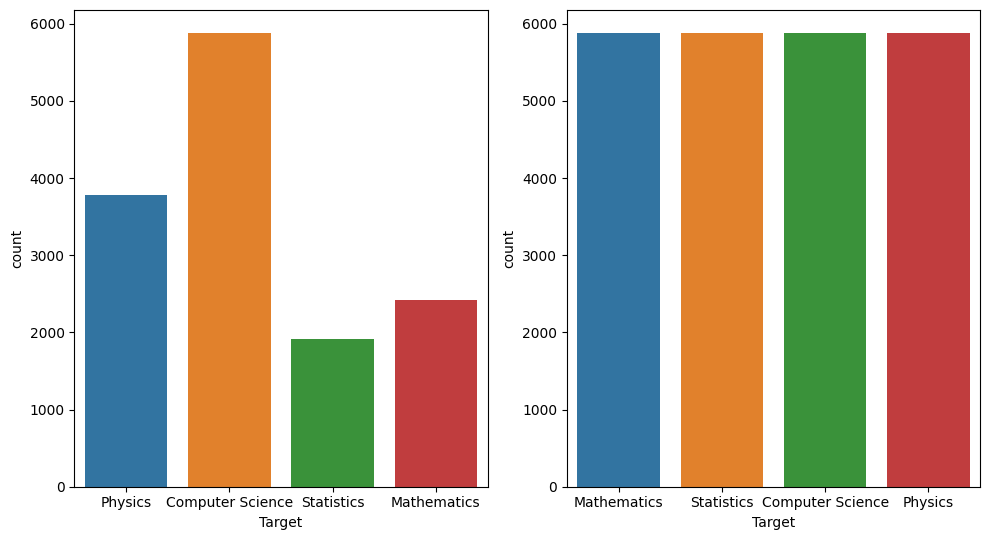

In [19]:
plt.rcParams["figure.figsize"] = [10.00, 5.50]
plt.rcParams["figure.autolayout"] = True
f, axes = plt.subplots(1, 2)
sns.countplot(data=train_df, x='Target', ax=axes[0])
sns.countplot(data=balanced_df_ml, x='Target', ax=axes[1])

# Machine Learning with Scikit Learn

In [20]:
LABELS = ['Computer Science', 'Mathematics', 'Physics', 'Statistics']

In [21]:
x_train, x_test, y_train, y_test = train_test_split(tfidf, balanced_df_ml['Target'], 
                                                    test_size=0.2, random_state=42)

In [22]:
def model_training(model, x_train, y_train, x_test, y_test):
    """
    Trains the given model using the provided training data and evaluates it using the test data.

    Args:
        model: The machine learning model to be trained.
        x_train: The training data features.
        y_train: The training data labels.
        x_test: The test data features.
        y_test: The test data labels.

    Returns:
        array-like: The predicted labels for the test data.
    """
    
    model = model
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    return y_pred

In [23]:
def plot_confusion_matrix(y_true, y_pred, labels):
    """
    Plots a confusion matrix using the true and predicted labels.

    Args:
        y_true (array-like): The true labels.
        y_pred (array-like): The predicted labels.
        labels (array-like): The list of labels to index the matrix.
    """
    
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

## Logistic Regression

In [24]:
lr = LogisticRegression(C=1, max_iter=1000, n_jobs=-1, solver='newton-cg')
y_pred_lr = model_training(model=lr, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)
accuracy_score(y_test,y_pred_lr)

0.9186491079014444

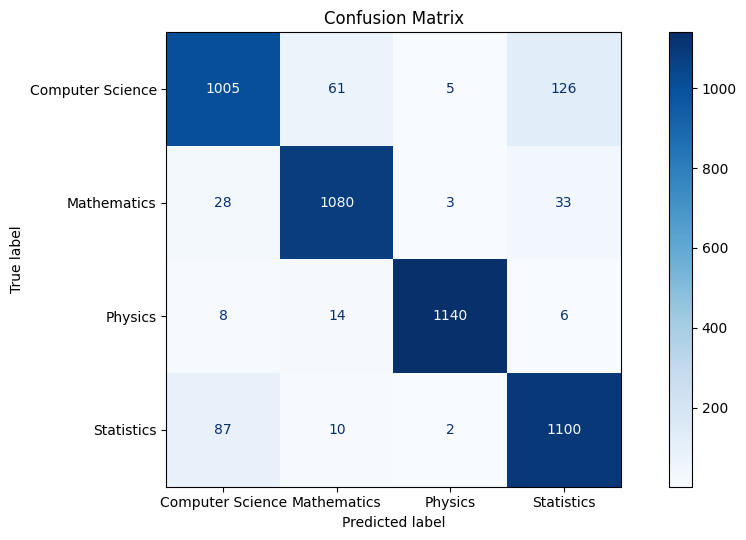

In [25]:
plot_confusion_matrix(y_test, y_pred_lr, LABELS)

In [26]:
print(classification_report(y_test, y_pred_lr))

                  precision    recall  f1-score   support

Computer Science       0.89      0.84      0.86      1197
     Mathematics       0.93      0.94      0.94      1144
         Physics       0.99      0.98      0.98      1168
      Statistics       0.87      0.92      0.89      1199

        accuracy                           0.92      4708
       macro avg       0.92      0.92      0.92      4708
    weighted avg       0.92      0.92      0.92      4708



## Multinomial Naive Bayes

In [27]:
nb = MultinomialNB(alpha=0.8)
y_pred_nb = model_training(model=nb, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)
accuracy_score(y_test,y_pred_nb)

0.8759558198810535

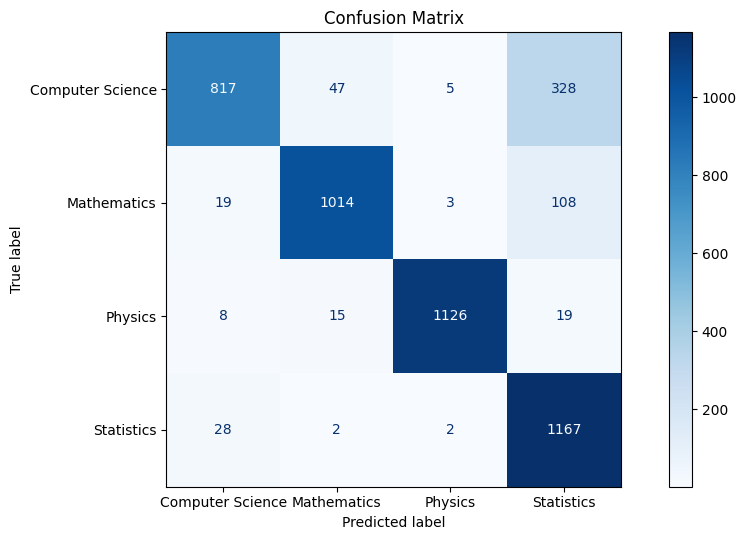

In [28]:
plot_confusion_matrix(y_test, y_pred_nb, LABELS)

In [29]:
print(classification_report(y_test, y_pred_nb, zero_division=0))

                  precision    recall  f1-score   support

Computer Science       0.94      0.68      0.79      1197
     Mathematics       0.94      0.89      0.91      1144
         Physics       0.99      0.96      0.98      1168
      Statistics       0.72      0.97      0.83      1199

        accuracy                           0.88      4708
       macro avg       0.90      0.88      0.88      4708
    weighted avg       0.90      0.88      0.88      4708



# Deep Learning with PyTorch

## Model Preparation

In [30]:
class TextDataset(Dataset):
    """
    A custom dataset class for text data.

    Args:
        texts (list of list of int): A list of tokenized texts, where each text is a list of token IDs.
        labels (list of int): A list of labels corresponding to the texts.
    """
    
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        
    def __len__(self):
        """Returns the number of samples in the dataset."""
        return len(self.texts)
    
    def __getitem__(self, idx):
        """Retrieves the sample and label at the given index."""
        return torch.tensor(self.texts[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

In [31]:
text_data = torch.tensor(balanced_df_dl['Preprocessed Text'].values.tolist())
target = torch.tensor(balanced_df_dl['Target'].values)
X, y = text_data, target

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_train, X_val, X_test, y_train, y_val, y_test = X_train.to(device), X_val.to(device), X_test.to(device), y_train.to(device), y_val.to(device), y_test.to(device)

In [33]:
train_dataset = TextDataset(X_train, y_train)
val_dataset = TextDataset(X_val, y_val)
test_dataset = TextDataset(X_test, y_test)

In [34]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True)

## Model Building

In [35]:
class TextClassifier(nn.Module):
    
    """
    A text classification model using an embedding layer, a bidirectional LSTM, and a linear layer.

    Args:
        vocab_size (int): The size of the vocabulary.
        embed_dim (int): The dimensionality of the embeddings.
        hidden_dim (int): The number of features in the hidden state of the LSTM.
        output_dim (int): The number of output classes.
    """
    
    def __init__(self, vocab_size:int, embed_dim:int, hidden_dim:int, output_dim:int):
        super(TextClassifier, self).__init__()
        
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim, padding_idx=0)
        
        self.lstm = nn.LSTM(input_size=embed_dim, hidden_size=embed_dim, dropout=0.5, 
                            bidirectional=True, batch_first=True, num_layers=2)
        
        self.linear = nn.Linear(in_features=embed_dim * 2, out_features=output_dim)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        """Forward pass of the model."""
        
        embedded = self.dropout(self.embedding(x))
        lstm_out, (hidden, cell) = self.lstm(embedded)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        output = self.linear(hidden)
        return output

In [36]:
# Hyperparameters
VOCAB_SIZE = len(vocab)
EMBED_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = 4

EPOCHS = 30

In [37]:
model = TextClassifier(vocab_size=VOCAB_SIZE, embed_dim=EMBED_DIM, 
                       hidden_dim=HIDDEN_DIM, output_dim=OUTPUT_DIM).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

## Model Training

In [38]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

for epoch in tqdm(range(EPOCHS+1)):
    
    for texts, labels in train_loader:
        model.train()
        output_logits = model(texts)
        loss = loss_fn(output_logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        y_pred = torch.softmax(output_logits, dim=1).argmax(dim=1)
        accuracy = accuracy_score(y_true=labels.to('cpu'), y_pred=y_pred.to('cpu')) * 100
        
    model.eval()
    with torch.inference_mode():
        for val_texts, val_labels in val_loader:
            val_logits = model(val_texts)
            val_loss = loss_fn(val_logits, val_labels)
            
            val_output = torch.softmax(val_logits, dim=1).argmax(dim=1)
            val_acc = accuracy_score(y_true=val_labels.to('cpu'), y_pred=val_output.to('cpu')) * 100
    
    if epoch % 5 == 0:
        print(f'Epoch: {epoch} | Train Loss: {loss.item():.4f} & Train Accuracy: {accuracy:.1f}% | Val Loss: {val_loss.item():.4f} & Val Accuracy: {val_acc:.1f}%')

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.0495 & Train Accuracy: 51.5% | Val Loss: 1.0078 & Val Accuracy: 52.2%
Epoch: 5 | Train Loss: 0.5348 & Train Accuracy: 75.8% | Val Loss: 0.6897 & Val Accuracy: 73.9%
Epoch: 10 | Train Loss: 0.5638 & Train Accuracy: 77.3% | Val Loss: 0.5463 & Val Accuracy: 78.9%
Epoch: 15 | Train Loss: 0.4498 & Train Accuracy: 83.3% | Val Loss: 0.6236 & Val Accuracy: 78.9%
Epoch: 20 | Train Loss: 0.3790 & Train Accuracy: 87.1% | Val Loss: 0.5311 & Val Accuracy: 82.0%
Epoch: 25 | Train Loss: 0.2991 & Train Accuracy: 89.4% | Val Loss: 0.2888 & Val Accuracy: 86.3%
Epoch: 30 | Train Loss: 0.3756 & Train Accuracy: 86.4% | Val Loss: 0.3518 & Val Accuracy: 89.4%


## Model Testing

In [39]:
model.eval()
with torch.inference_mode():
    for texts, labels in test_loader:
        output_logits = model(texts)
        output = torch.softmax(output_logits, dim=1).argmax(dim=1)

## Evaluation

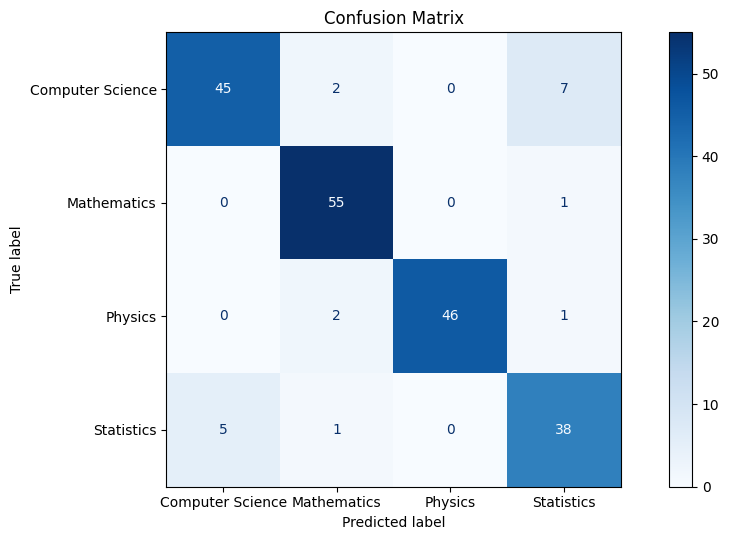

In [40]:
plot_confusion_matrix(labels.to('cpu'), output.to('cpu'), LABELS)

In [41]:
print(classification_report(labels.to('cpu'), output.to('cpu')))

              precision    recall  f1-score   support

           0       0.90      0.83      0.87        54
           1       0.92      0.98      0.95        56
           2       1.00      0.94      0.97        49
           3       0.81      0.86      0.84        44

    accuracy                           0.91       203
   macro avg       0.91      0.90      0.90       203
weighted avg       0.91      0.91      0.91       203



# Example 

In [42]:
example_text = "stars are self-gravitating fluids inside which pressure, buoyancy, rotation and magnetic fields provide "\
"a restoring forces considering global modes of oscillation. pressure and buoyancy energetically dominate, while rotation and magnetism " \
"are generally assumed to be weak perturbations and often ignored. however, observations of anomalously weak dipole mode amplitudes inside "\
"red giant stars suggest that the substantial fraction of these are subject to an additional source of damping localised to their core region, "\
"with indirect evidence pointing to a role of the deeply buried magnetic field. it was also known that inside many instances a gravity-mode character "\
"of affected modes was preserved, but so far no effective damping mechanism has been proposed that accommodates this aspect. here we present such the mechanism, "\
"which damps a oscillations of stars harbouring magnetised cores using resonant interactions with standing alfvén modes of high harmonic index. a damping rates "\
"produced by this mechanism are quantitatively on par with those associated with turbulent convection, and inside a range required to explain observations, considering "\
"realistic stellar models and magnetic field strengths. our results suggest that magnetic fields should provide an efficient means of damping stellar oscillations without "\
"needing to disrupt a internal structure of a modes, and lay a groundwork considering an extension of a theory of global stellar oscillations that incorporates these effects."

example_target = 'Physics'
example_label = 2

In [43]:
encoded_text = encode(preprocess_text(text=example_text, ml=False))
encoded_text = torch.unsqueeze(torch.tensor(encoded_text).to(device), 0)
encoded_text

tensor([[  126,   712,     2,   577,  6052,   899,    85,    39,    69,  7144,
           865,     3,   258,   368,  1361,   577,  6052,  5203,  4067,   899,
          2272,   929,  1369,   547,   548,   233,  4080,    59,    92,  7223,
           547,  2458,   368,  1059,     2,  1999,  1168,   126,   611,  1407,
           686,   808,   476,   131,  2352,  7390,   562,   164,  2474,   556,
          4174,   461,  5451,  6717,    85,    39,    16,   153,     2,    91,
           564,  1012,  1706,   368,  3172,   821,   236,  2352,   265,    22,
          6691,   725,    26,   265,  9910,  1361,   126,     1, 14870,   562,
           202,  2366,   102,  6413,  8444,   368,    74,  1487,   689,  2352,
            79,  1250,   265,  2231,  4912,   270,  1329,  2651,     2,   169,
           539,   908,    92,     3,   955,   321,     4,    85,    39,   764,
             8,   611,    85,    39,    69,   175,   187,  2352,   321,  1361,
           167,  6837,  9147,  1262,    30,   368,  

In [44]:
model.eval()
with torch.inference_mode():
    output_logits = model(encoded_text)
    output = torch.softmax(output_logits, dim=1).argmax(dim=1)
    
output == example_label

tensor([True], device='cuda:0')